<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/09_logistic_regression_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 糖尿病をロジスティック回帰で予測してみる

* 有名なPima Indians Diabetes Databaseを使う

https://www.kaggle.com/uciml/pima-indians-diabetes-database

### 1) データの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
diabetes = pd.read_csv('diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

In [5]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### 2) テストデータの分離

In [6]:
from sklearn.model_selection import train_test_split

# （この分割は変えないようにしてください。）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123)

In [7]:
X_test.shape

(116, 8)

In [8]:
X_train.shape

(652, 8)



---



（ここから自由に試行錯誤をスタートさせましょう。）



---



### 3) EDA

* いくつかの属性についてはおかしな値があることに注意。

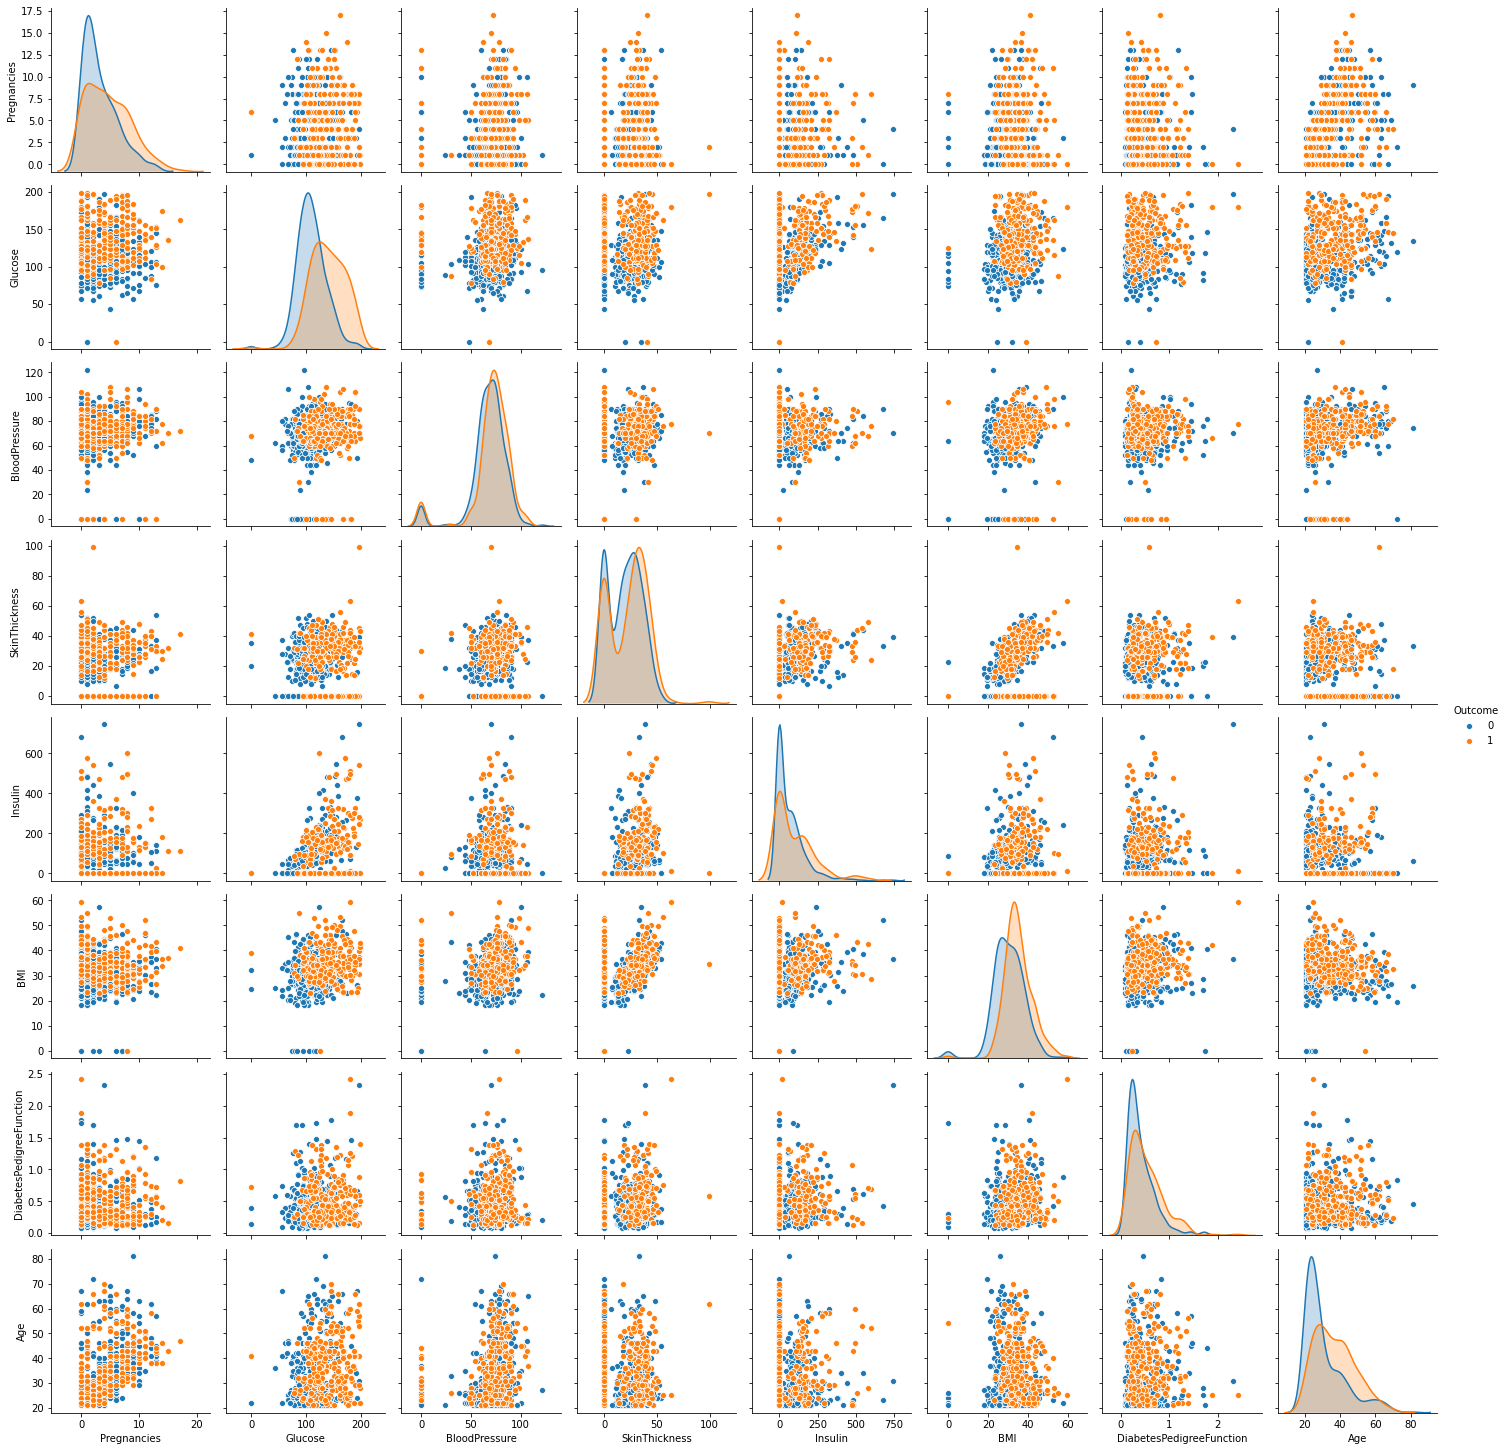

In [9]:
# training dataについては正解（つまりOutcome）を使ってもいいので、
# ヒストグラムと散布図を、Outcomeが0か1かで区別して描いてみる

diabetes_train = diabetes.iloc[X_train.index]
sns.pairplot(diabetes_train, hue='Outcome').savefig('diabetes_train_plot.png')

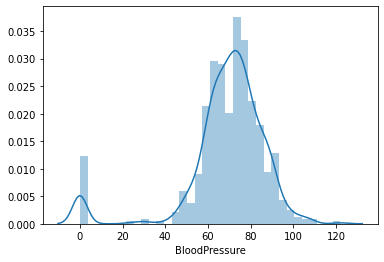

In [10]:
# まず、属性「BloodPressure」について、ヒストグラムを描いてよくよく眺める。

sns.distplot(X_train['BloodPressure'])

In [11]:
# 0という値がけっこうあるらしい。実は、これは欠測値。そこで、中央値で埋めることにする。
# （この前処理の仕方で正しいという保証はありません。）

bp_median = np.median(X_train[X_train.BloodPressure != 0]['BloodPressure'])
print(bp_median)
X_train = X_train.replace({'BloodPressure':0}, bp_median)

72.0


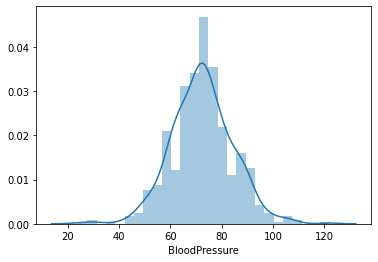

In [12]:
# もう一度、ヒストグラムを描く。

sns.distplot(X_train['BloodPressure'])

In [13]:
# test dataの「BloodPressure」の欠測値も、training dataと同じ値で埋める。
# この作業は、training dataから得られる情報しか使っていないので、ズルはしていない。

X_test = X_test.replace({'BloodPressure':0}, bp_median)

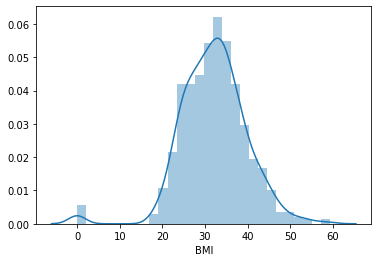

In [14]:
# 次に、training dataの「BMI」のヒストグラムを描いてみる

sns.distplot(X_train['BMI'])

32.4


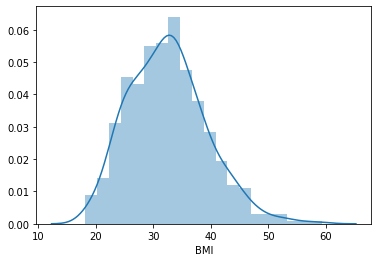

In [15]:
# やはり欠測値の部分が0とされているようなので、先ほどと同様、中央値で埋める。

bmi_median = np.median(X_train[X_train.BMI != 0]['BMI'])
print(bmi_median)
X_train = X_train.replace({'BMI':0}, bmi_median)
sns.distplot(X_train['BMI'])

In [16]:
# test dataのBMIの欠測値も、同じ値で埋める 

X_test = X_test.replace({'BMI':0}, bmi_median)

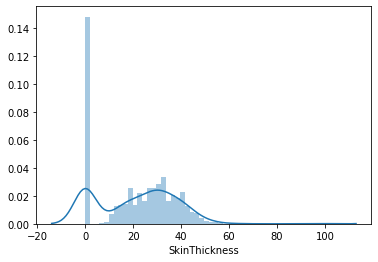

In [17]:
# 「SkinThickness」はどうだろう。

sns.distplot(X_train['SkinThickness'], bins=50)

In [18]:
# どうやら0とされた欠測値が多すぎるようだ。
# 中央値や平均値で埋めると、同じ値で埋められた場所を大量に作ることになってしまう。
# そこで、k-近傍法を使って、埋めることにする。

indices1 = X_train[X_train.SkinThickness != 0].index
indices0 = X_train[X_train.SkinThickness == 0].index

In [19]:
# SkinThicknessが欠損値でない個体から近傍を求める

X_kNN = X_train.loc[indices1].drop('SkinThickness', axis=1)
X_missing = X_train.loc[indices0].drop('SkinThickness', axis=1)

In [20]:
# k=3とする（特に根拠はない。もっと良い決め方はないか？）

k = 3
# SkinThicknessが欠損値である個体をひとつづつ見ていくループ
for idx in indices0:
  x = X_missing.loc[idx]
  # SkinThicknessが欠損値でない個体とのL2ノルムを求める
  norm = (X_kNN - x).apply(np.linalg.norm, axis=1)
  # 求めたL2ノルムを昇順にソートし、インデックスを並べかえる
  indices_top_k = norm.index[np.argsort(norm)][:k]
  # 最も近かったk個のSkinThicknessの平均で、欠損部分を埋める
  X_train.loc[idx,'SkinThickness'] = X_train.loc[indices_top_k,'SkinThickness'].mean() 

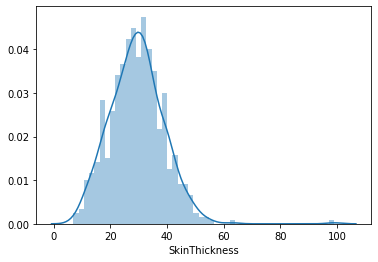

In [21]:
# あらためてヒストグラムを描いてみる。

sns.distplot(X_train['SkinThickness'], bins=50)

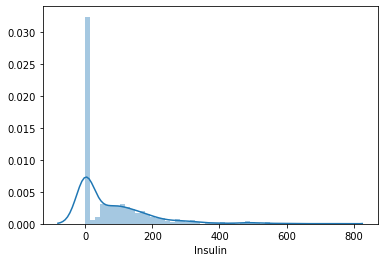

In [22]:
# Insulinはどうだろう。

sns.distplot(X_train['Insulin'], bins=50)

In [23]:
# Insulinはそのままにしておいてみよう。

### 4) 交差検証の準備

* 10-foldクロスバリデーションをおこなってみる。

  * scikit-learnのStratifiedKFoldを使う。
  * StratifiedKFoldは、ただのKFoldと、何が違うか、調べよう。


In [24]:
# 交差検証の準備
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [25]:
for train_index, valid_index in skf.split(X_train, y_train):
  print(valid_index)

[  0   5  12  13  15  17  20  26  38  41  46  53  56  66  67  71 102 103
 114 131 136 138 141 169 198 202 225 229 231 249 251 259 267 273 283 299
 346 371 372 376 382 384 426 442 450 459 485 486 495 499 512 516 526 528
 530 536 538 545 561 570 581 604 607 624 642 645]
[  9  22  52  69  92 123 126 137 144 148 149 163 250 254 262 269 271 272
 306 311 315 319 322 325 353 368 370 373 383 388 411 418 424 435 455 456
 457 460 461 472 474 479 481 490 492 514 515 520 525 541 558 567 571 572
 576 601 605 612 620 622 623 625 626 635 639 644]
[  2  11  21  34  59  86  90  93 108 115 118 120 122 128 139 140 142 153
 154 190 194 197 245 263 268 270 281 300 312 318 320 321 329 349 356 364
 387 395 396 400 403 405 425 463 466 480 482 489 493 497 500 509 556 579
 594 600 619 627 628 632 636 637 638 646 651]
[ 14  24  32  43  44  58  61  79  81  88 159 161 162 165 171 175 180 181
 186 189 201 205 206 208 216 220 232 233 234 278 287 293 294 307 309 313
 326 338 339 342 359 366 390 393 401 423 437 438 44

### 5)　ロジスティック回帰によるOutcomeの予測を検証データ上で評価する

In [26]:
from sklearn.linear_model import LogisticRegression

scores = list()
for train_index, valid_index in skf.split(X_train, y_train):

  # ロジスティック回帰の学習
  logreg = LogisticRegression(max_iter=1000, random_state=123)
  logreg.fit(X_train.iloc[train_index], y_train.iloc[train_index])

  # 検証データでの評価
  score = logreg.score(X_train.iloc[valid_index], y_train.iloc[valid_index])
  print('score: {:.4f}'.format(score))
  scores.append(score)

print('mean score: {:.4f}'.format(np.array(scores).mean()))

score: 0.8030
score: 0.8030
score: 0.7538
score: 0.7231
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.7846
score: 0.7231
score: 0.7538
mean score: 0.7683


### 6) スケーラーを使ってみる。

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [28]:
scores = list()
for train_index, valid_index in skf.split(X_train, y_train):

  # ロジスティック回帰の学習
  logreg = LogisticRegression(max_iter=1000, random_state=123)
  logreg.fit(scaler.transform(X_train.iloc[train_index]), y_train.iloc[train_index])

  # 検証データでの評価
  score = logreg.score(scaler.transform(X_train.iloc[valid_index]), y_train.iloc[valid_index])
  print('score: {:.4f}'.format(score))
  scores.append(score)

print('mean score: {:.4f}'.format(np.array(scores).mean()))

score: 0.7727
score: 0.8182
score: 0.7538
score: 0.7385
score: 0.7846
score: 0.8000
score: 0.7385
score: 0.7692
score: 0.7385
score: 0.7538
mean score: 0.7668


### 7) 正則化パラメータCをチューニングする。

In [29]:
for C in np.power(10.0, np.arange(13) - 5):

  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):
    # ハイパーパラメータCを、10の-5乗から、10の5乗まで、10倍ずつ動かす
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=123)
    logreg.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    score = logreg.score(X_train.iloc[valid_index], y_train.iloc[valid_index])
    scores.append(score)

  print('C: {}; mean score: {:.4f}'.format(C, np.array(scores).mean()))

C: 1e-05; mean score: 0.7346
C: 0.0001; mean score: 0.7590
C: 0.001; mean score: 0.7652
C: 0.01; mean score: 0.7668
C: 0.1; mean score: 0.7637
C: 1.0; mean score: 0.7683
C: 10.0; mean score: 0.7683
C: 100.0; mean score: 0.7683
C: 1000.0; mean score: 0.7683
C: 10000.0; mean score: 0.7683
C: 100000.0; mean score: 0.7698
C: 1000000.0; mean score: 0.7683
C: 10000000.0; mean score: 0.7683


In [30]:
# なぜかC=100000.0で良くなっているが偶然かもしれない。
# 結局、Cについてはデフォルト設定が一番良かったので、これを採用。
# テストセットで最終評価。

logreg = LogisticRegression(max_iter=1000, random_state=123)
logreg.fit(X_train, y_train)
print('test score: {:.4f}'.format(logreg.score(X_test, y_test)))

test score: 0.7672
